This code accompanies the paper submitted on July 1, 2019: Theory of time-resolved optical conductivity of
superconductors: comparing two methods for its evaluation.

Here we import the important packages and define the useful functions for this analysis.

In [4]:
%pylab inline
from scipy import interpolate

def fourier_transform(tax,fax,f_t):
    M = outer(fax,tax)
    A = exp(1.j*M)
    return inner(A,f_t)

def search(value,axis,error): 
    for it in arange(len(axis)):
        if abs(axis[it]-value) < error:
            return it
    print("Value not found.")  
    return()

Populating the interactive namespace from numpy and matplotlib


$\textbf{horizontal_FT:}$ general function that calculates fourier transform of 2D array of data along horizontal cuts. Here the inputs are as follows: 

$\textbf{data:}$ is expected to be 2D array with horizontal axis identified with time axis tax_h. 

$\textbf{tax_h:}$ should be evenly spaced time axis identifed with the horizontal axis of data. 

$\textbf{decay:}$ (default False) indicates whether the Fourier transform should be done after convolving with a decaying exponential (characterized by variable tau) to smooth the Fourier transform. (See also: decay_param)

$\textbf{padding:}$ (default False) indicates whether to increase the resolution of frequency axis by appending zeros to the end of the horizontal strips- this only is recommended if the signal is zero for quite a while before the sampling along horizontal axis ends. 

$\textbf{pad_len:}$ integer that indicates how much padding you would like to apply: if it is not set, the default is the length of the horizontal axis, doubling the length of the signal and the frequency resolution. Only applied if padding == True.

$\textbf{decay_param:}$ parameter used to characterize the strength of the decay if decay is set to True. 

This function returns a frequency axis fax and FT, a 3-dimensional array of fourier transform-ed data. The first index of this array specifies whether you are referring to the real (0) or imaginary part (1) of the fourier transform. The second index is identified with the number of the data set fed in as a horizontal strip of data, starting with 0. The third index is identified with the returned frequency axis fax. If padding is set to True in function call, this will return the new time axis tax as a 3rd output.

In [5]:
def horizontal_FT(data,tax_h,decay=False,padding=False,pad_len=0,decay_param=0):
    assert len(tax_h) == len(data[0,:]), "tax_h and x-axis of data must have same length."
    tax = copy(tax_h)
    if padding & (abs(pad_len) < 0.5): 
        pad_len = len(data[0,:])
        pad = zeros(int(pad_len))
        taxpadding = zeros_like(pad)
        for it in arange(len(taxpadding)):
            taxpadding[it] = max(tax_h) + (it+1)*(tax_h[1]-tax_h[0])
        tax = concatenate((tax_h,taxpadding))
    fax = fft.fftshift(fft.fftfreq(len(tax),d=tax[1]-tax[0]))
    FT = zeros((2,len(data[:,0]),len(fax)))
    for it in arange(len(FT[0,:,0])):
        if padding:
            strip = concatenate((data[it,:],pad))
        else:
            strip = data[it,:]
        if decay:
            strip *= exp(-(tax-tax[0])/decay_param)       # provides the decay to smooth FT.
        f_w = fourier_transform(tax,fax,strip)
        FT[0,it,:] = real(f_w)
        FT[1,it,:] = imag(f_w)
    if padding: return fax,FT,tax
    return fax,FT

$\textbf{horizontal_conductivity:}$ specialized function that can be used to calculate optical conductivity as described in Method I (horizontal cuts, or variant $t_{gate}$) in the paper. This function calls horizontal_FT, defined above, and its arguments are as follows:

$\textbf{current:}$ electric current as a function of $t_{gate}$ and $t_{pp}$. Assumes that $t_{gate}$ is identified with the horizontal axis and $t_{pp}$ with the vertical axis. 

$\textbf{E_t:}$ probe electric field as a function of tax_h. Assumed same shape as tax_h.

$\textbf{tax_h:}$ evenly spaced horizontal time axis.

$\textbf{decay:}$ (default False) indicates whether the $\textit{current}$ should be multiplied by a decaying exponential before taking fourier transform. This has a smoothing effect in frequency domain. (See also: current_decay_param)

$\textbf{E_decay:}$ (default False) indicates whether the $\textit{electric field}$ should be multiplied by a decaying exponential before taking fourier transform. This has a smoothing effect in frequency domain. (See also: E_decay_param)

$\textbf{padding:}$ (default false) indicates whether to increase the resolution of frequency axis by appending zeros to the end of the horizontal strips- this only is recommended if the signal is zero for quite a while before the sampling along horizontal axis ends. Affects both electric field and optical conductivity.

$\textbf{pad_len:}$ integer that indicates how much padding you would like to apply: if it is not set, the default is the length of the horizontal axis, doubling the length of the signal and the frequency resolution. Only applied if padding == True.

$\textbf{current_decay_param:}$ parameter used to characterize the strength of the decay in electric current if decay is set to True. 

$\textbf{E_decay_param:}$ parameter used to characterize the strength of the decay in electric field if E_decay is set to True.

In [6]:
def horizontal_conductivity(current,E_t,tax_h,decay=False,E_decay=False,
                            padding=False,pad_len=0,current_decay_param=1,E_decay_param=1):
    
    if padding: 
        freq,J_w,tax = horizontal_FT(current,tax_h,decay,padding,pad_len,current_decay_param)
        field = concatenate((E_t,zeros((len(tax)-len(tax_h)))))
    else: 
        freq,J_w = horizontal_FT(current,tax_h,decay,padding,pad_len,current_decay_param)
        tax = tax_h
        field = E_t
    if E_decay:
        field *= exp(-(tax-tax[0])/E_decay_param)
    E_w = fourier_transform(tax,freq,field)
    conductivities = zeros_like(J_w)
    for it in arange(len(J_w[0,:,0])):
        conductivities[0,it-1,:] = real((J_w[0,it,:] + 1j*J_w[1,it,:])/E_w )
        conductivities[1,it-1,:] = imag((J_w[0,it,:] + 1j*J_w[1,it,:])/E_w )
    return freq,conductivities

We use this to calculate conductivity for a set of current data with 60 values of $t_{pp}$. Note that the probe field E_t and the pump field (not included) are the same for each value of $t_{pp}$. To illustrate the usage of this code, we do one calculation with weak decay parameter 250 for both current and electric field, and one without this part of the code implemented. Here we use the convention $\sigma = \sigma_1 + i \, \sigma_2$.

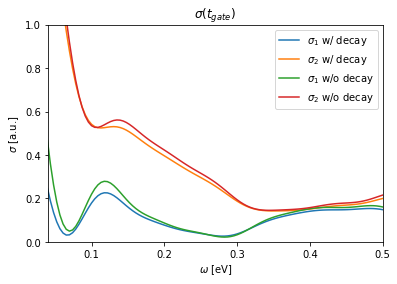

In [7]:
for it in arange(1,60):
    globals()['J'+str(it)] = genfromtxt('J'+str(it)+'.dat')
t_gate = J1[:,0]
current_data = zeros((59,len(J1[:,1])))
for it in arange(1,59):
    current_data[it,:] = globals()['J'+str(it)][:,1]
E_t = genfromtxt("E.dat")[:575,1]    # generates sample electric field as a function of time.
fax,with_decay = horizontal_conductivity(current_data,E_t,t_gate,decay=True,
                                         E_decay=True,padding=True,current_decay_param=250,
                                         E_decay_param=250)
fax,no_decay = horizontal_conductivity(current_data,E_t,t_gate,decay=False,
                                       E_decay=True,padding=True,current_decay_param=250,
                                       E_decay_param=250)

fig,ax = subplots()
ax.plot(fax,with_decay[0,0,:],label='$\sigma_1$ w/ decay')
ax.plot(fax,with_decay[1,0,:],label='$\sigma_2$ w/ decay')
ax.plot(fax,no_decay[0,0,:],label='$\sigma_1$ w/o decay')
ax.plot(fax,no_decay[1,0,:],label='$\sigma_2$ w/o decay')
ax.set_xlim(0.04,0.5)
ax.set_ylim(0,1)
ax.set_title('$\sigma (t_{gate})$')
ax.set_xlabel('$\omega$ [eV]')
ax.set_ylabel('$\sigma$ [a.u.]')
ax.legend()
show()

Note the similarities between the corresponding components of the conductivity calculated with and without the damping exponential: the curves are in both cases qualitatively similar, with dips and peaks at the same frequencies, but the conductivities calculated with a decay are overall slightly lower.

vertical_FT: calculates fourier transform of 2D array along vertical axis after performing vertical interpretation and shifting the data to give data as a function of $t_{gate}$ and the pump-probe time $t_{pp}$ as done in Method II of the paper. Potential issue: when used alonside method I, results may need to be normalized due to differnece in signal length in time domain before taking fourier transform. Returns an extended horizontal axis, a frequency axis, and array of fourier transforms. The array of fourier transforms is just as the one described above in horizontal_FT.

Here the inputs are as follows:

$\textbf{aligned_data:}$ 2D array of data with x-axis identified with tax_h and y-axis identified with tax_v.

$\textbf{tax_h:}$ time axis associated with the x-axis of aligned_data.

$\textbf{tax_v:}$ time axis assoicated with the y-axis of aligned_data.

$\textbf{decay:}$ (default False) whether the data should be multiplied by a decaying exponential before taking fourier transform in order to smooth fourier transform in frequency domain.

$\textbf{pad_len:}$ (default 0) non-negative integer; how much padding to apply to end of signal. Padding here refers to appending 0's to end of the signal in time domain before taking fourier transform. Applying padding to a signal may increase resolution in frequency domain, but should only be done when the signal is 0 for a while towards the end in order to avoid inaccuracy in fourier transform.

$\textbf{decay_param:}$ if decay == True, the parameter used to characterize the strength of the decay.

In [15]:
def do_interp(aligned_data,tax_h,tax_v):
    
    # We calculate the location of the peak in one of the original horizontal cuts.     
    spacing = tax_h[1] - tax_h[0]
    vmin = tax_v[0]
    vmax = tax_v[-1]
    vsteps = int(1 + (vmax-vmin)/spacing)
    new_tax_v = linspace(vmin,vmax,vsteps)
    interpolated_data = zeros((len(tax_h),len(new_tax_v)))
    for it in arange(len(tax_h)):
        vstrip = aligned_data[:,it]
        fit = interpolate.Akima1DInterpolator(tax_v,vstrip)
        interpolated_data[it,:] = fit(new_tax_v)
    hmin = min(tax_h) + min(tax_v)
    hmax = max(tax_h) + max(tax_v)
    hsteps = int(1 + (hmax-hmin)/spacing)
    new_tax_h = linspace(hmin,hmax,hsteps)
    shifted_data = zeros((len(new_tax_h),len(new_tax_v)))
    for it in arange(len(new_tax_v)):
        shifted_data[it:it+len(tax_h),it] = interpolated_data[:,it]
    
    return new_tax_h,new_tax_v,shifted_data



def vert_FT(aligned_data,tax_h,tax_v,decay=False,cut_param=75,decay_param=0,padding=0):
    new_tax_h,new_tax_v,shifted_data = do_interp(aligned_data,tax_h,tax_v)    
    print(shape(new_tax_h))
    spacing = tax_h[1] - tax_h[0]
    
    if padding == True:
        t_padding = linspace(max(new_tax_v)+spacing,max(new_tax_v)+spacing*pad_len,pad_len)
        t_pp = concatenate((new_tax_v,t_padding))
    else:
        t_pp = new_tax_v
        
    fax = fft.fftshift(fft.fftfreq(len(t_pp),d=spacing))
    FT = zeros((2,len(new_tax_h),len(fax)))
    
    #FT_ax = linspace(0,spacing*len(aligned_data[:,0]),len(aligned_data[0,:]))
    
    lcut = argmax(aligned_data[:,0]) - cut_param
    rcut = len(aligned_data[:,0])-lcut
    t1 = tax_h[argmax(aligned_data[:,0])]
    for it in arange(len(new_tax_h)):
        shifted_strip = flip(shifted_data[it,:])
        peak = argmax(shifted_strip)
        if peak >= lcut and peak + rcut < len(fax):
            vert = shifted_strip[0:peak+rcut]
        else: # peak < lcut
            cut = shifted_strip[0:int(lcut-peak+rcut)]
            vert = concatenate((zeros((len(fax)-len(cut))),cut))
        t2 = t_pp[argmax(cut)]
        #return(shape(FT_ax-t2+t1),shape(fax),shape(vert))
        vert_w = fourier_transform(t_pp - t2 + t1, fax, vert)
        FT[0,it,:] = real(vert_w)
        FT[1,it,:] = imag(vert_w)    
    return new_tax_h,fax,FT

In [ ]:
probe_center = genfromtxt('probe_center.dat')[:,1]
t_gate,v_fax,FT_method_two = vert_FT(current_data,t_gate,probe_center)

Below is an example of how vertical_FT may also be used to calculate the optical conductivity $\sigma$, as in Method II of the paper.

NameError: name 'vfreqs' is not defined

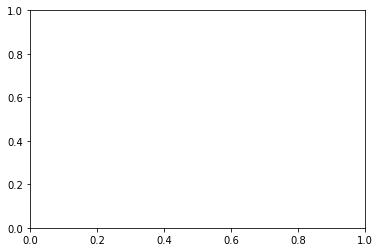

In [16]:
fig,ax = subplots()
ax.plot(vfreqs,vFT[0,1000,:],label='$\sigma_1$ w/ decay,$t_{gate}=$'+str(t_gate_ax[1000]))
ax.plot(vfreqs,vFT[1,1000,:],label='$\sigma_2$ w/ decay,$t_{gate}=$'+str(t_gate_ax[1000]))
ax.set_xlim(0.04,0.5)
ax.set_title('$\sigma (t_{pp})$')
ax.set_xlabel('$\omega$ [eV]')
ax.set_ylabel('$\sigma$ [a.u.]')
ax.legend()
show()